In [1]:
# Download All Dependencies
!pip install -q kaggle

In [ ]:
# Upload API Files from Kaggle
from google.colab import files
files.upload()

In [3]:
# Connect Collab to Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
# Download Datasets
!kaggle datasets download -d andrewmvd/animal-faces

 99% 692M/696M [00:24<00:00, 29.8MB/s]
100% 696M/696M [00:24<00:00, 29.9MB/s]


In [5]:
# Extract Datasets and Preprocessing Files
!unzip animal-faces.zip
!mv afhq animal_faces

# Remove All data into train
!mv ./animal_faces/val/cat/* ./animal_faces/train/cat/
!mv ./animal_faces/val/dog/* ./animal_faces/train/dog/
!mv ./animal_faces/val/wild/* ./animal_faces/train/wild/

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [6]:
# Rename All Files
import os

data_cat = os.listdir("./animal_faces/train/cat")
data_dog = os.listdir("./animal_faces/train/dog")
data_wild = os.listdir("./animal_faces/train/wild")

for i, data in enumerate(data_cat):
    os.rename(f"./animal_faces/train/cat/{data}", f"./animal_faces/train/cat/{i}.jpg")

for i, data in enumerate(data_dog):
    os.rename(f"./animal_faces/train/dog/{data}", f"./animal_faces/train/dog/{i}.jpg")

for i, data in enumerate(data_wild):
    os.rename(f"./animal_faces/train/wild/{data}", f"./animal_faces/train/wild/{i}.jpg")

In [7]:
# Split data into 80% train and 20% val
import shutil

for i in range(int((len(data_cat) * 20) / 100)):
    shutil.move(f"./animal_faces/train/cat/{i}.jpg", f"./animal_faces/val/cat/{i}.jpg")

for i in range(int((len(data_dog) * 20) / 100)):
    shutil.move(f"./animal_faces/train/dog/{i}.jpg", f"./animal_faces/val/dog/{i}.jpg")

for i in range(int((len(data_wild) * 20) / 100)):
    shutil.move(f"./animal_faces/train/wild/{i}.jpg", f"./animal_faces/val/wild/{i}.jpg")

In [8]:
# Rename All Files again
import os

data_cat_train = os.listdir("./animal_faces/train/cat")
data_cat_val = os.listdir("./animal_faces/val/cat")
data_dog_train = os.listdir("./animal_faces/train/dog")
data_dog_val = os.listdir("./animal_faces/val/dog")
data_wild_train = os.listdir("./animal_faces/train/wild")
data_wild_val = os.listdir("./animal_faces/val/wild")

for i, data in enumerate(data_cat_train):
    os.rename(f"./animal_faces/train/cat/{data}", f"./animal_faces/train/cat/{i}.jpg")

for i, data in enumerate(data_cat_val):
    os.rename(f"./animal_faces/val/cat/{data}", f"./animal_faces/val/cat/{i}.jpg")

for i, data in enumerate(data_dog_train):
    os.rename(f"./animal_faces/train/dog/{data}", f"./animal_faces/train/dog/{i}.jpg")

for i, data in enumerate(data_dog_val):
    os.rename(f"./animal_faces/val/dog/{data}", f"./animal_faces/val/dog/{i}.jpg")

for i, data in enumerate(data_wild_train):
    os.rename(f"./animal_faces/train/wild/{data}", f"./animal_faces/train/wild/{i}.jpg")

for i, data in enumerate(data_wild_val):
    os.rename(f"./animal_faces/val/wild/{data}", f"./animal_faces/val/wild/{i}.jpg")

In [9]:
# Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=.20,
    zoom_range=0.2,
    fill_mode="nearest",
    brightness_range=[0.5, 1.0]
)

val_datagen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=.20,
    zoom_range=0.2,
    fill_mode="nearest",
    brightness_range=[0.5, 1.0]
)

In [10]:
# Create classification

train_generator = train_datagen.flow_from_directory(
    os.path.join("./animal_faces/train"),
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical',
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join("./animal_faces/val"),
    target_size=(150, 150),
    batch_size=256,
    class_mode='categorical',
)

Found 9241 images belonging to 3 classes.
Found 1647 images belonging to 3 classes.


In [11]:
# Create Neural Network
import tensorflow as tf

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1028, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(3, activation="softmax")                                   
])

In [12]:
# Create Callbacks
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95:
            print("\nValidasi Accuracy telah mencapai > 95%!")
            self.model.stop_training = True

callback0 = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)
callback1 = Callback()

In [13]:
# Create Compile
model.compile(optimizer="Adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [14]:
# Train Model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=[callback0, callback1],
                    epochs=50,)

Epoch 1/50
37/37 [==============================] - 151s 3s/step - loss: 1.3517 - accuracy: 0.4353 - val_loss: 0.9528 - val_accuracy: 0.5707
Epoch 2/50
37/37 [==============================] - 114s 3s/step - loss: 0.8163 - accuracy: 0.6578 - val_loss: 0.9537 - val_accuracy: 0.4111
Epoch 3/50
37/37 [==============================] - 115s 3s/step - loss: 0.4043 - accuracy: 0.8427 - val_loss: 0.7468 - val_accuracy: 0.7298
Epoch 4/50
37/37 [==============================] - 115s 3s/step - loss: 0.2928 - accuracy: 0.8904 - val_loss: 0.7451 - val_accuracy: 0.6600
Epoch 5/50
37/37 [==============================] - 114s 3s/step - loss: 0.2595 - accuracy: 0.9004 - val_loss: 0.7290 - val_accuracy: 0.6132
Epoch 6/50
37/37 [==============================] - 115s 3s/step - loss: 0.2218 - accuracy: 0.9187 - val_loss: 0.2802 - val_accuracy: 0.9290
Epoch 7/50
37/37 [==============================] - 114s 3s/step - loss: 0.1544 - accuracy: 0.9428 - val_loss: 0.3257 - val_accuracy: 0.8604
Epoch 8/50
37

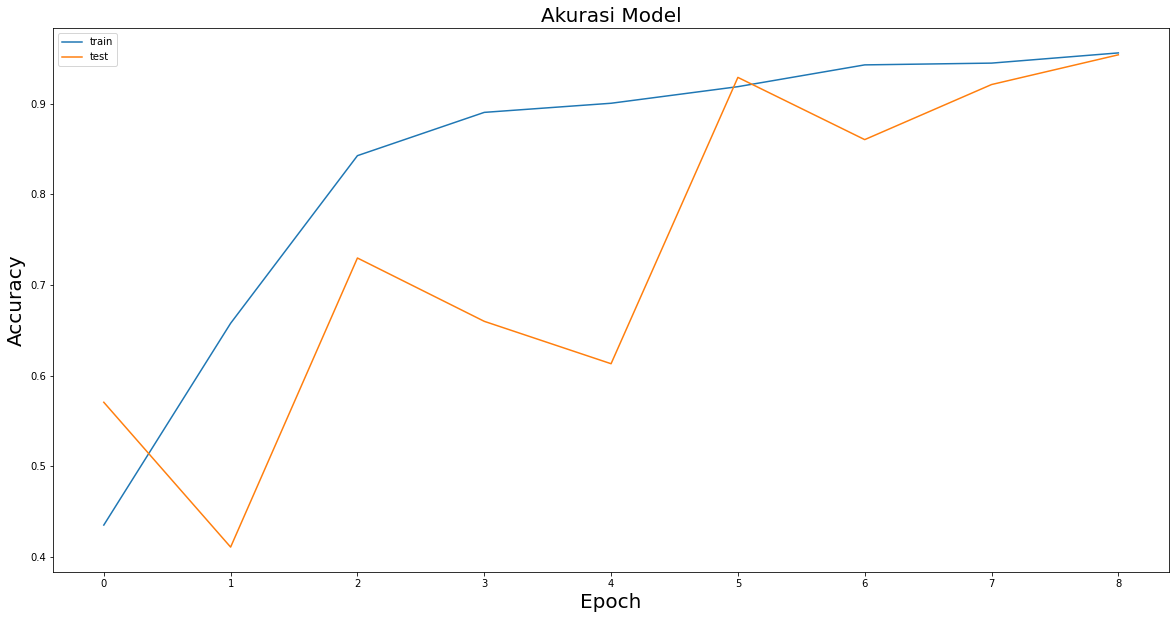

In [15]:
# Plot accuracy model
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

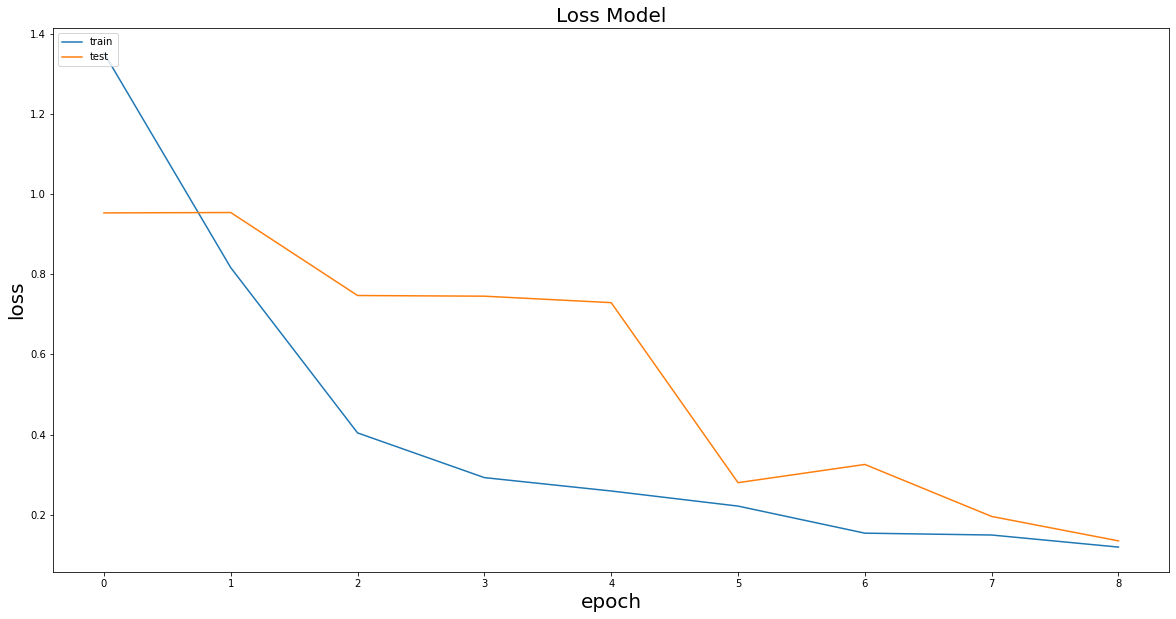

In [16]:
# Plot Loss Function model
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Convert into TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpaoc2lf8x/assets


In [18]:
# Save Data
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)